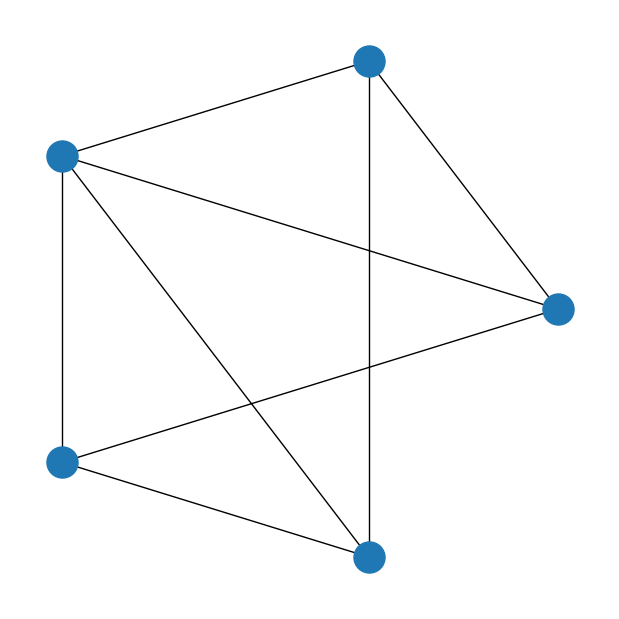

In [1]:
import numpy as np
from src.viz import simple_graph_from_adj, generate_sbm, plot_sbm, MySbmFromScratch
import networkx as nx

matrix = np.array([[0,1,1,1,0],
                  [1,0,1,0,1],
                  [1,1,0,1,1],
                  [1,0,1,0,1],
                  [0,1,1,1,0]])

simple_graph_from_adj(matrix, labels=False)

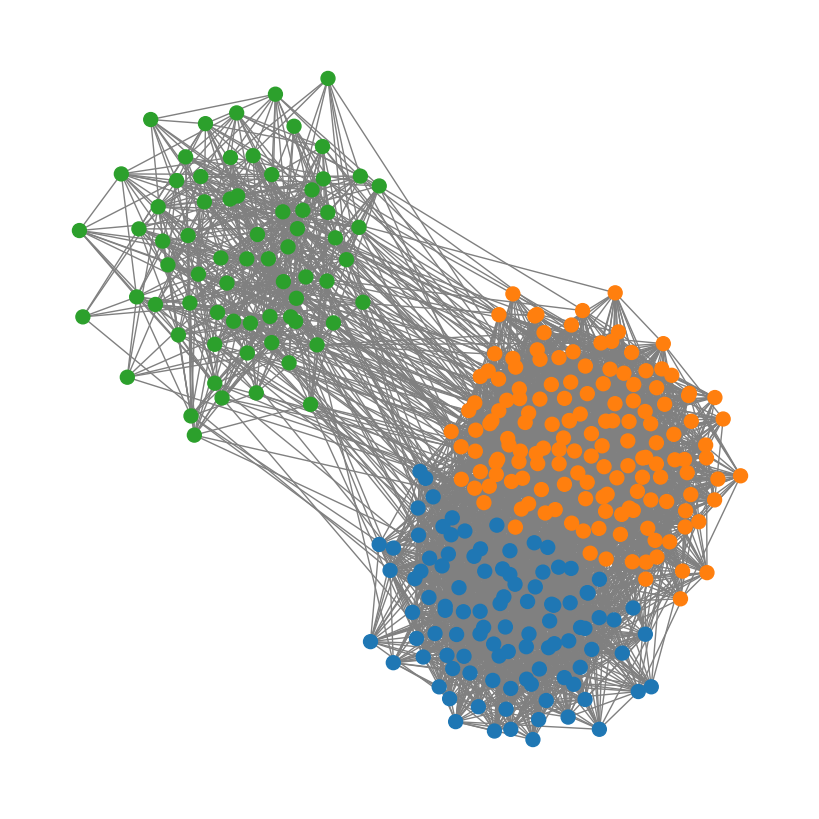

In [2]:
n_classes = [100, 150, 70]

probs = np.array([
    [0.2, 0.05, 0.005],
    [0.05, 0.15, 0.01],
    [0.005, 0.01, 0.2]
])

G = generate_sbm(n_classes, probs)

plot_sbm(G, n_classes)


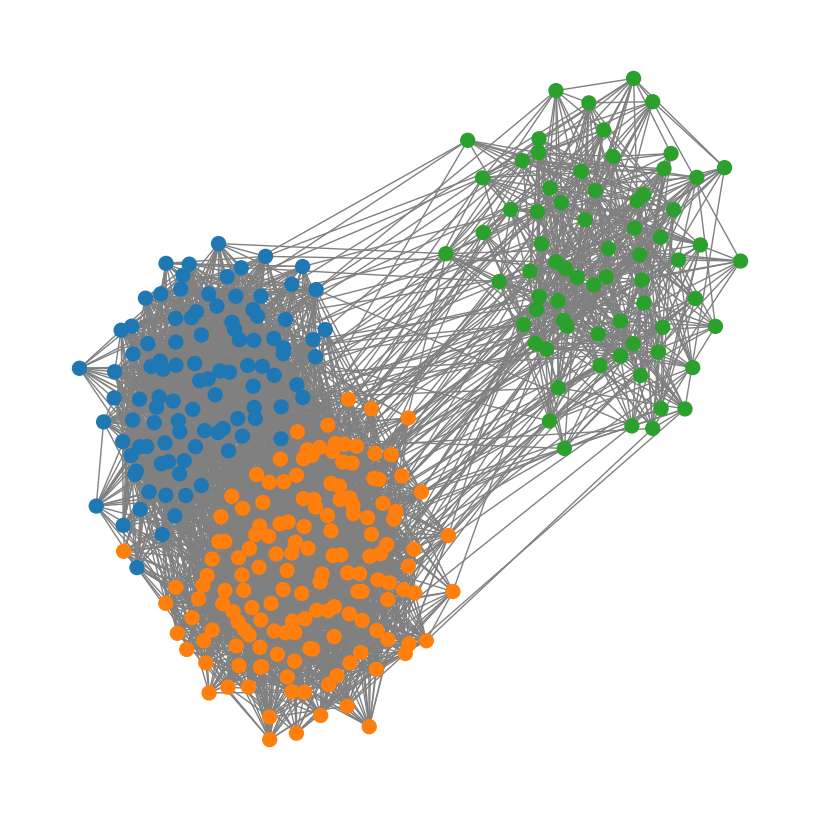

In [3]:
sbm = MySbmFromScratch()

sbm.generate_graph(n_classes = n_classes, probs = probs)
sbm.plot_graph()


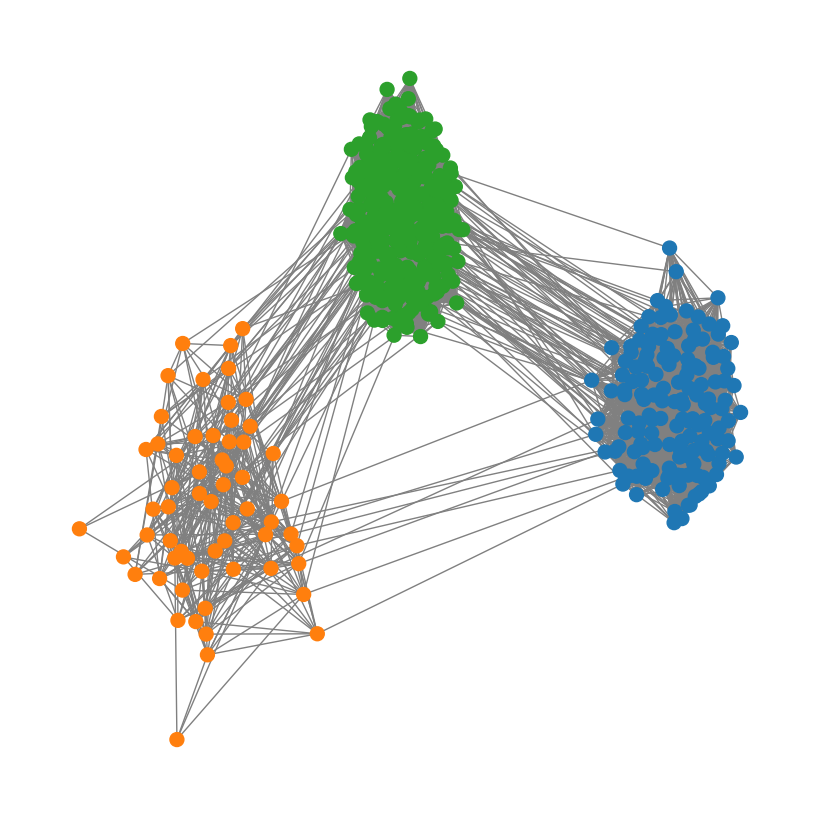

In [12]:
sbm = MySbmFromScratch()

sbm.generate_graph(N = 500, K=3, _lambda=0.2, multiplier=0.02, alpha=2)
sbm.plot_graph()
